In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

In [2]:
import os
import re
import sys
import math
import pathlib
import warnings
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
from TELF.factorization import SymNMFk
sys.path.append("../../scripts/")

## 1. Load Example Data

In [4]:
DATA_PATH = "../../data/symnmf"
DATA_PATH = pathlib.Path(DATA_PATH).resolve()

In [5]:
def tryint(s):
    try:
        return int(s)
    except ValueError:
        return s
    
def alphanum_key(s):
    """ 
    Turn string into a list of strings and numbers
    
    Parameters:
    -----------
    s: str
        The string to chunk
        
    Returns:
    --------
    list
        Chunked number and string list
        
    Example:
    --------
    >>> alphanum_key('a123b')
    ['a', 123, 'b']
    """
    return [tryint(c) for c in re.split('([0-9]+)', s)]

In [6]:
data_files = sorted([x for x in os.listdir(DATA_PATH) if x.endswith('.csv')], key=alphanum_key)
data_files

['0.csv',
 '1.csv',
 '2.csv',
 '3.csv',
 '4.csv',
 '5.csv',
 '6.csv',
 '7.csv',
 '8.csv',
 '9.csv',
 '10.csv']

In [7]:
def load_csv_to_numpy(path, dtype=np.float32):
    """
    Loads the content of a CSV file into a numpy array.
    
    Parameters:
    -----------
    path: str
        The file path to the CSV file.
        
    Returns:
    --------
    np.ndarray
        A numpy array containing the data from the CSV file.
    """
    return np.loadtxt(path, delimiter=',', dtype=dtype)

### Visualize the 2-Dimensional Data

Cannot visualize data from 9.csv, shape=(46, 3), in a 2D scatter plot
Cannot visualize data from 10.csv, shape=(39, 3), in a 2D scatter plot


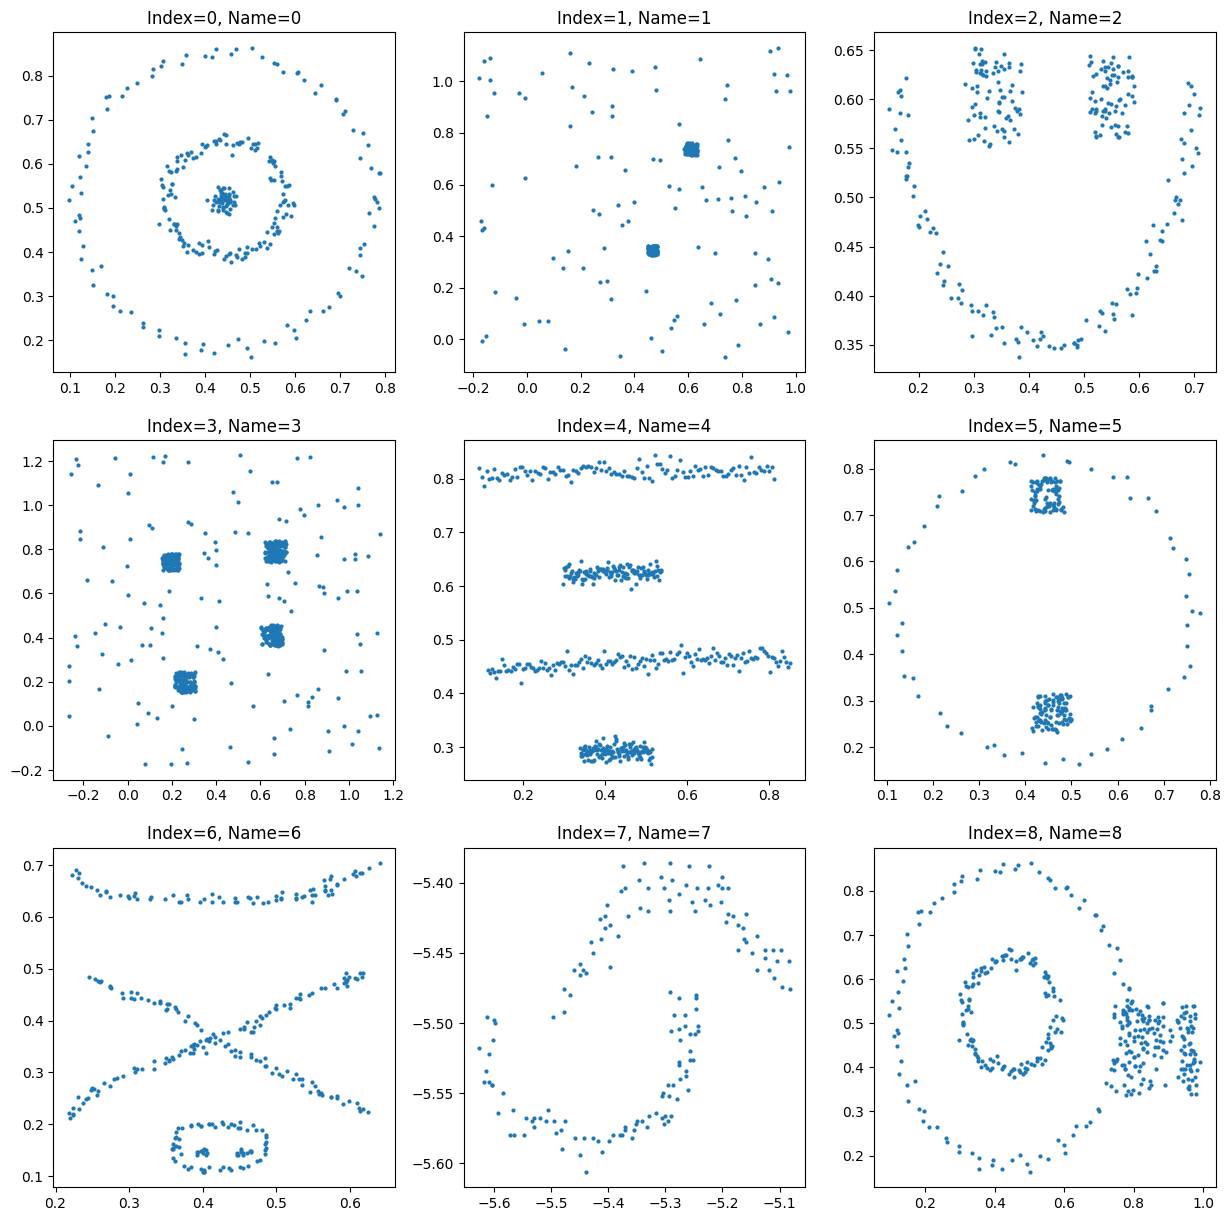

In [8]:
num_cols = 3
num_entries = 0
for i, f in enumerate(data_files):
    data = load_csv_to_numpy(os.path.join(DATA_PATH, f))
    if data.shape[1] == 2:
        num_entries += 1

num_rows = math.ceil(num_entries / num_cols)
fig, axs = plt.subplots(num_rows, num_cols, dpi=100, figsize=(15,15))

data_2d = {}
for i, f in enumerate(data_files):
    name = pathlib.Path(f).stem
    data = load_csv_to_numpy(os.path.join(DATA_PATH, f))
    if data.shape[1] != 2:
        print(f'Cannot visualize data from {f}, shape={data.shape}, in a 2D scatter plot', file=sys.stderr)
        continue
    
    data_2d[name] = data
    axs[i // num_rows, i % num_cols].scatter(data[:, 0], data[:, 1], s=4)
    axs[i // num_rows, i % num_cols].set_title(f'Index={i}, Name={name}')
    
plt.show()

## 2. SymNMFk

### Settings

In [12]:
params = {
    "n_iters": 1000,
    "n_perturbs":64,
    "epsilon":0.0001,
    "n_jobs":8,
    "use_gpu":False,
    "save_path":"../../results/",
    "save_output":True,
    "collect_output":True,
    "verbose":True,
    "pac_thresh":0.15,
    "graph_type": "full",
    "similarity_type": "gaussian",
    "nearest_neighbors": 7,
    "nmf_method": 'newton',
    "nmf_obj_params": # Parameters for SymNMF
    {
        "tol": 1e-4, 
        "sigma": 0.1, 
        "beta": 0.1, 
        "debug": 0,
    },
    "transpose":False,
    "calculate_pac":True,
    "use_consensus_stopping":True,
    "perturb_type":"uniform",
}

Ks = range(1,7,1)
model = SymNMFk(**params)

Performing NMF with  newton


### A. Run SymNMFk for a Single Data Source

In [10]:
name = '4'
X = data_2d.get(name)
assert X is not None, 'Invalid `name` provided to data_2d.'

results = model.fit(X, Ks, f'SymNFMk_{name}', f'SymNMFk Clustering {name} data')
labels = results['clusters']

/opt/conda/envs/TELF311/lib/python3.11/site-packages/TELF-0.0.2-py3.11.egg/TELF/factorization/SymNMFk.py:451: UserWarning: Requested 8 jobs but only processing 6 k values!
  0%|          | 0/6 [00:00<?, ?it/s]/opt/conda/envs/TELF311/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
100%|██████████| 6/6 [02:29<00:00, 24.88s/it]


#### Visualize Results

In [ ]:
cmap = plt.cm.tab10
unique_labels = len(np.unique(labels))
new_cmap = ListedColormap(cmap.colors[:unique_labels])

plt.figure(dpi=60, figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=labels, label=labels, cmap=new_cmap, s=30)
plt.title(f'Name={name}, k={unique_labels}', fontsize=18)
plt.show()
plt.close()

### B. Run SymNMFk for Each Data Source

In [ ]:
cluster_labels = {}
for name, X in tqdm(data_2d.items()):    
    results = model.fit(X, Ks, f'SymNFMk_{name}', f'SymNMFk Clustering {name} data')
    cluster_labels[name] = results['clusters']

#### Visualize Results

In [ ]:
fig, axs = plt.subplots(num_rows, num_cols, dpi=100, figsize=(15,15))
for i, (name, X) in enumerate(data_2d.items()):
    labels = cluster_labels.get(name)
    if labels is None:
        continue
    
    cmap = plt.cm.tab10
    unique_labels = len(np.unique(labels))
    new_cmap = ListedColormap(cmap.colors[:unique_labels])

    axs[i // num_rows, i % num_cols].scatter(X[:, 0], X[:, 1], c=labels, label=labels, cmap=new_cmap, s=4)
    axs[i // num_rows, i % num_cols].set_title(f'Name={name}, k={unique_labels}')

plt.show()